In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import stft
import pywt
from scipy.ndimage import label
from scipy.interpolate import interp1d

In [2]:
# Read the text file into a DataFrame without header row and with specific column names
df = pd.read_csv('./data/lamhong2imu.txt', sep=' ', header=None, names=['timestamp', 'Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az'])

# Display the DataFrame
print(df)


        timestamp        Gx        Gy        Gz        Ax        Ay         Az
0      437773.020  0.030526 -0.032188 -0.031856 -1.457032  3.898439  -9.480474
1      437773.040 -0.069907  0.023014  0.069775  3.433596 -0.416992 -10.301763
2      437773.060  0.012434 -0.005782  0.005454 -2.471681  2.782228 -10.221685
3      437773.079  0.078553 -0.023342 -0.012033  1.416016 -0.551758  -9.405278
4      437773.099 -0.085605  0.011773  0.013435  1.402345  0.773438 -10.289068
...           ...       ...       ...       ...       ...       ...        ...
45657  438817.059 -0.063920  0.213582  0.013904  3.509767 -2.132814 -10.810552
45658  438817.078  0.091387 -0.284413 -0.025541 -4.244143  1.204102  -9.227544
45659  438817.098 -0.285815  0.281026  0.082677  3.607424  4.361330  -9.300786
45660  438817.118  0.334630 -0.263794 -0.149921 -4.773440 -5.686526 -11.771490
45661  438817.138 -0.280493  0.153317  0.146998  6.512699  9.839849  -8.175785

[45662 rows x 7 columns]


# Plot the  accelerometer data

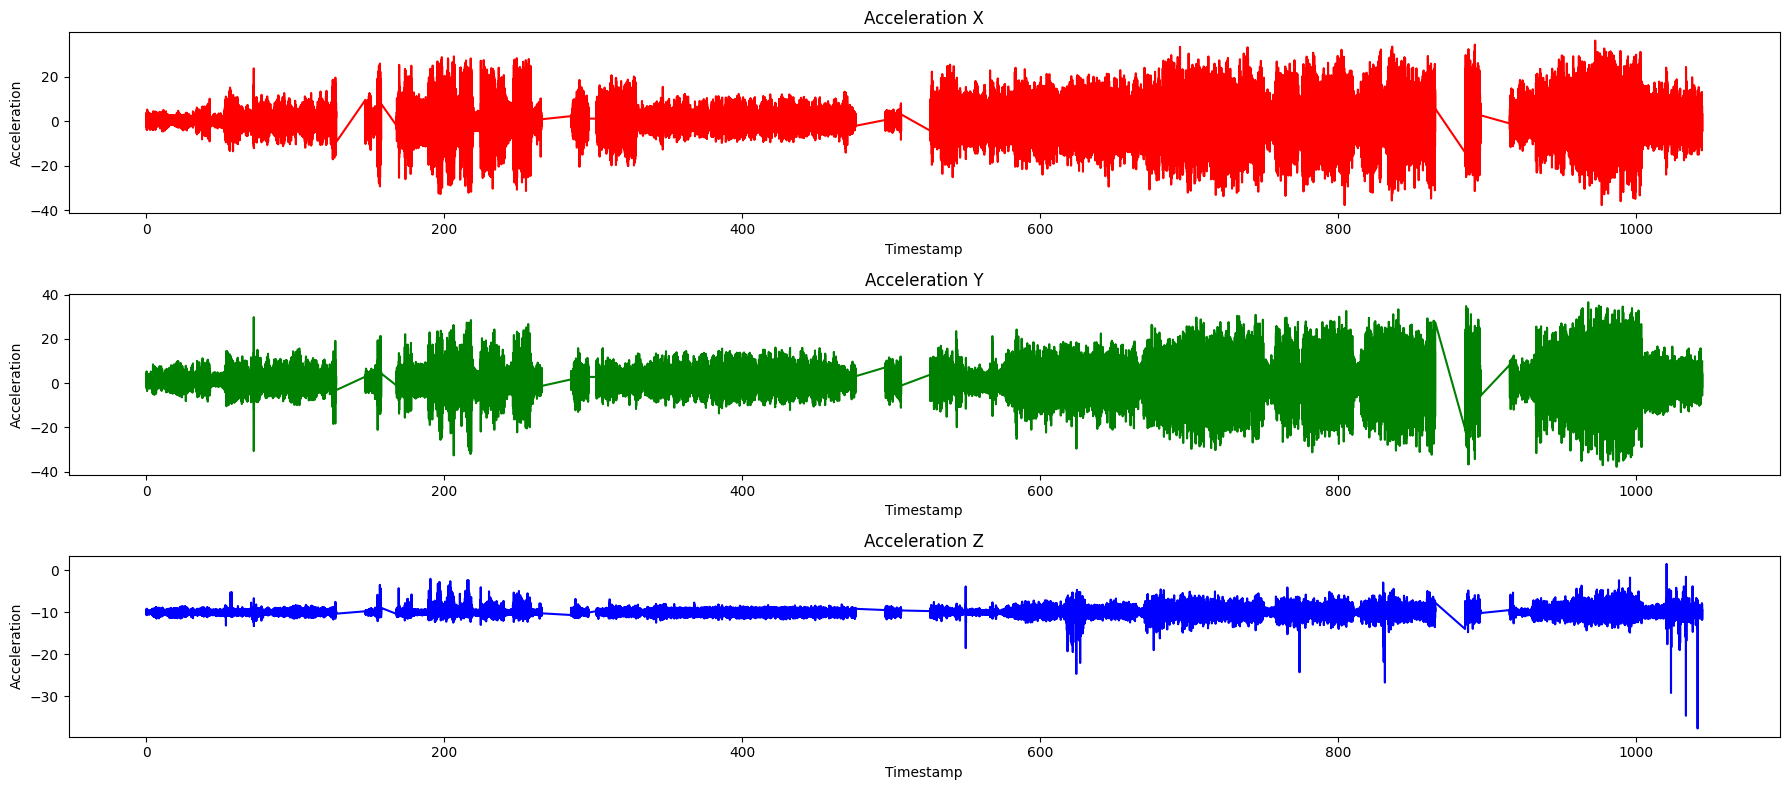

In [3]:
t = df['timestamp']
start_time = t[0]
t_norm = [time - start_time for time in t]

accel_x = df['Ax']
accel_y = df['Ay']
accel_z = df['Az']

# Creating subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 8))

# Plotting Ax
axs[0].plot(t_norm, accel_x, label="Ax", color='r')
axs[0].set_title('Acceleration X')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Acceleration')

# Plotting Ay
axs[1].plot(t_norm, accel_y, label="Ay", color='g')
axs[1].set_title('Acceleration Y')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Acceleration')

# Plotting Az
axs[2].plot(t_norm, accel_z, label="Az", color='b')
axs[2].set_title('Acceleration Z')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Acceleration')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('acceleration_plot.png')

# Apply Fast Fourier Transform

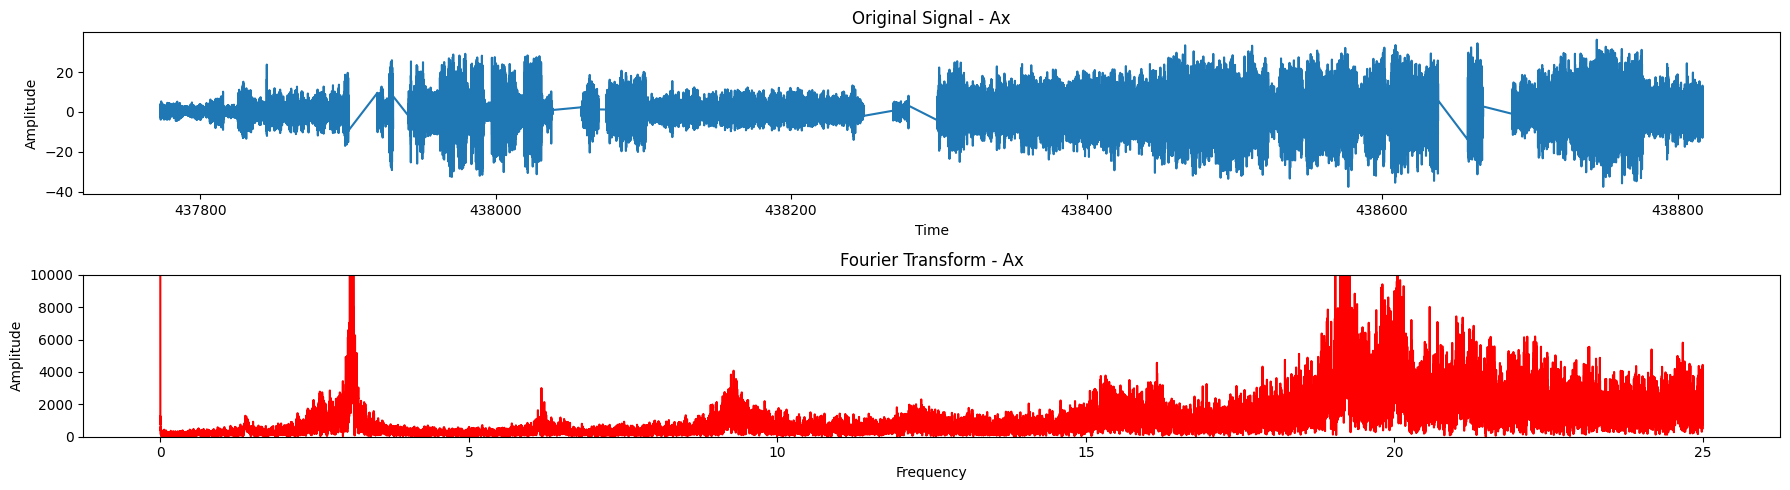

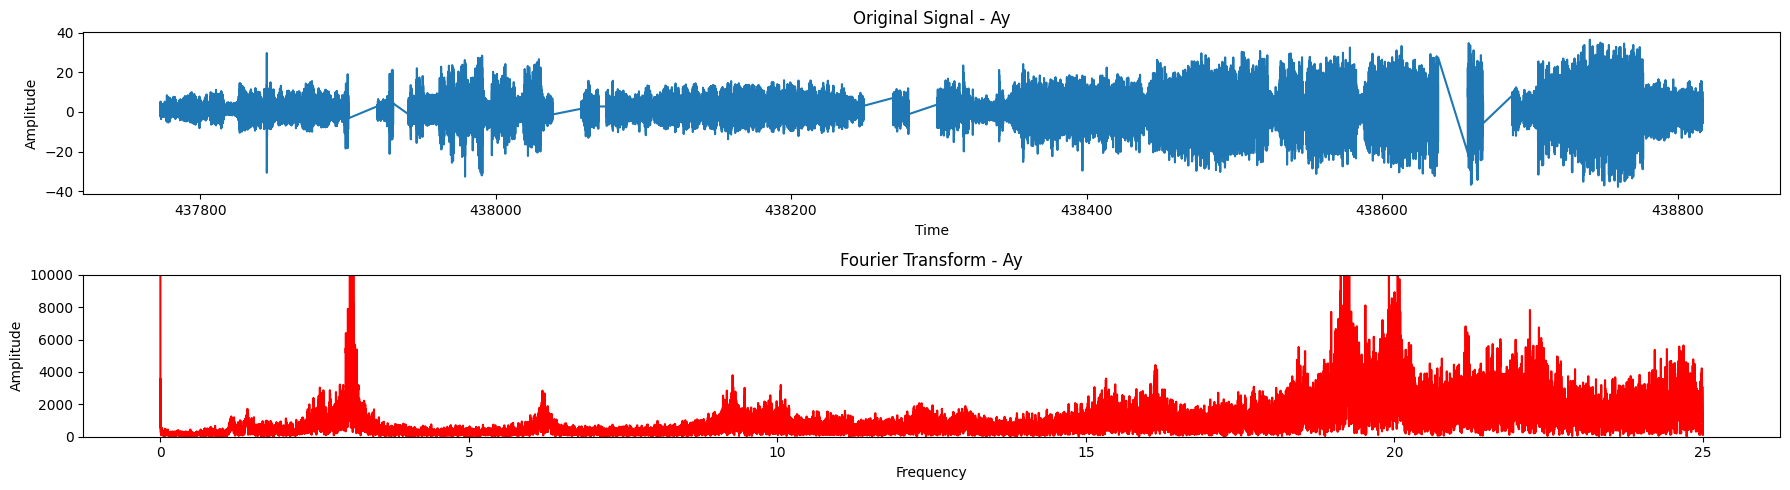

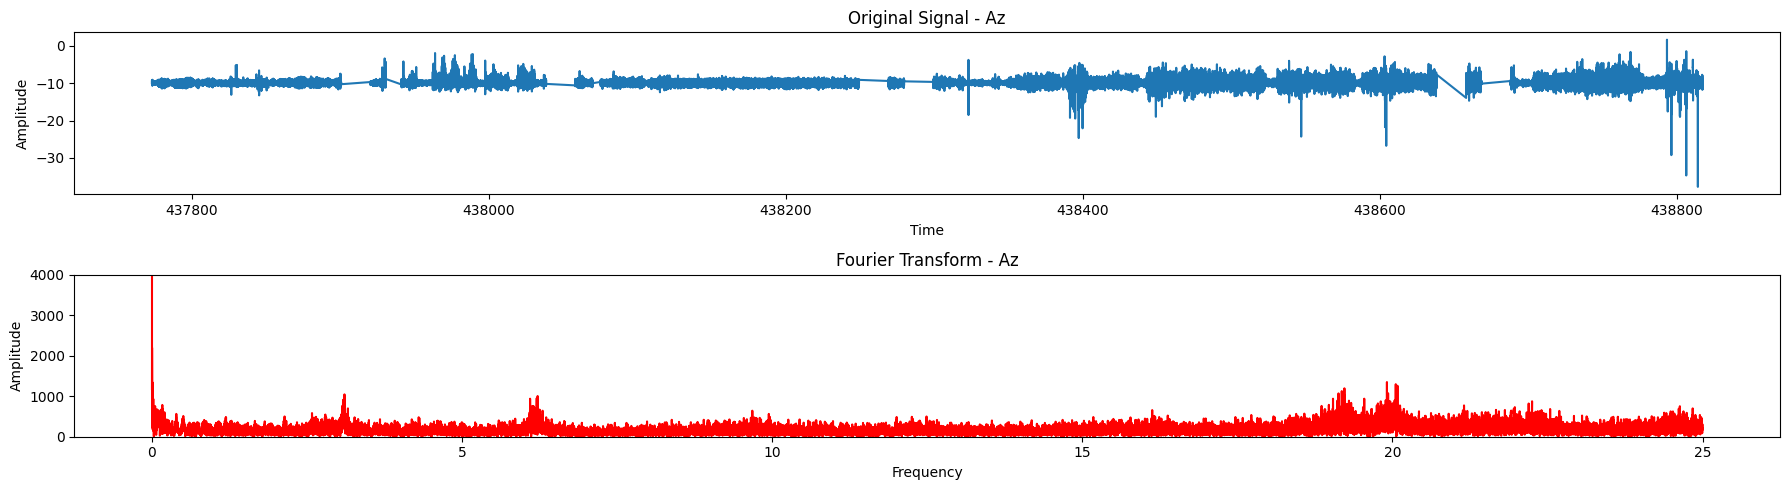

In [4]:
# Function to perform FFT and plot
def plot_fft(t, signal, title, ymax=10000):
    # Perform Fourier transform
    fourier_transform = np.fft.fft(signal)

    # Frequency domain
    freq = np.fft.fftfreq(len(signal), d=t[1]-t[0])

    positive_freqs = freq[:len(freq)//2]
    positive_spectrum = np.abs(fourier_transform)[:len(freq)//2]

    # Plot original signal and its Fourier transform
    plt.figure(figsize=(18, 5))

    plt.subplot(2, 1, 1)
    plt.plot(t, signal)
    plt.title('Original Signal - ' + title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(positive_freqs, np.abs(positive_spectrum), color='r')
    plt.title('Fourier Transform - ' + title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    
    # Adjust scale of y-axis
    plt.ylim(0, ymax)

    plt.tight_layout()
    plt.show()


# Plot FFT for Ax
plot_fft(t, accel_x, 'Ax')

# Plot FFT for Ay
plot_fft(t, accel_y, 'Ay')

# Plot FFT for Az
plot_fft(t, accel_z, 'Az', ymax=4000)

# Apply Short-time Fourier Transform

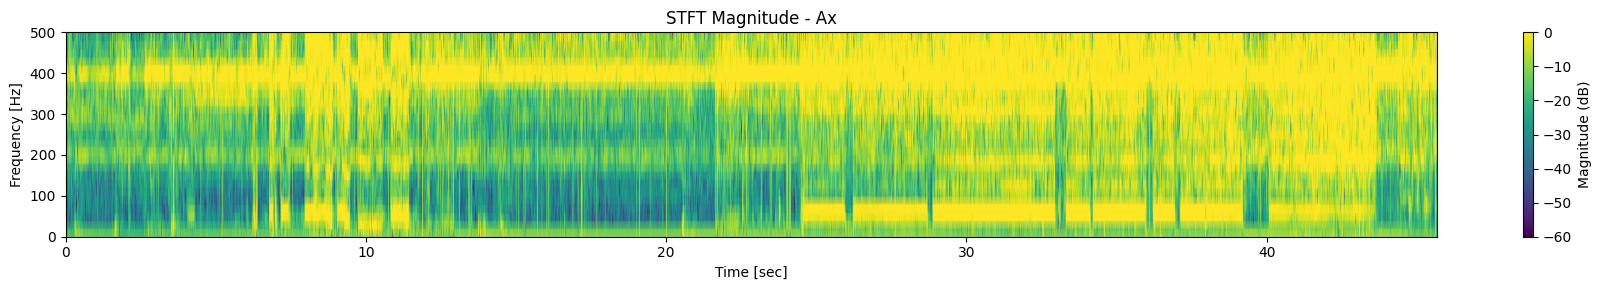

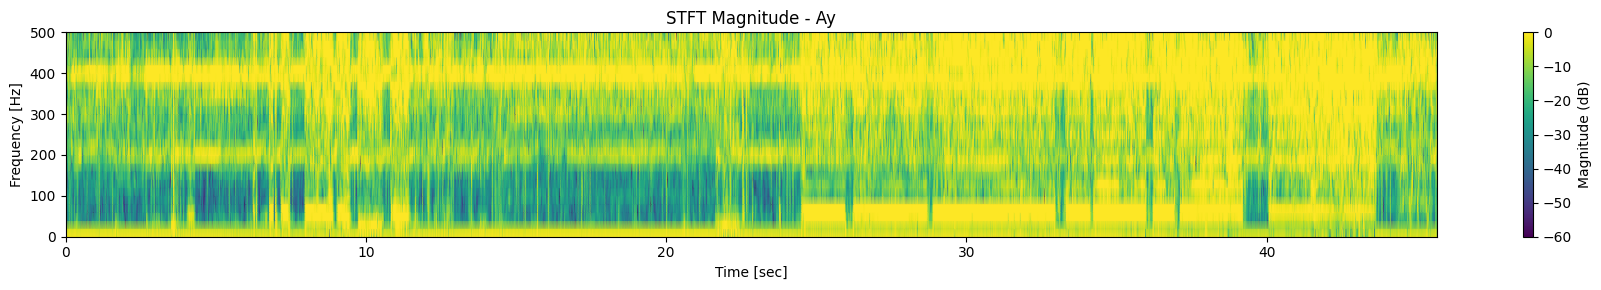

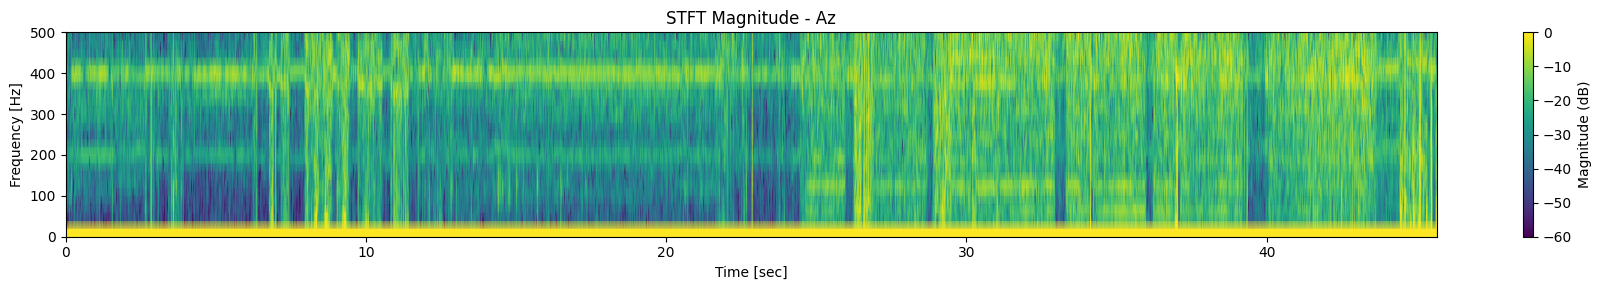

In [5]:
def plot_stft(signal, fs, title, scale=1.0, vmin=None, vmax=None, filename=None, use_log_scale=False):
    # Perform Short-Time Fourier Transform (STFT)
    f, t, Zxx = stft(signal, fs=fs, nperseg=50, noverlap=25)
    
    # Convert magnitude to logarithmic scale if needed
    magnitude = np.abs(Zxx) * scale
    if use_log_scale:
        magnitude = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)
    
    # Plot STFT result
    plt.figure(figsize=(18, 3))
    plt.pcolormesh(t, f, magnitude, shading='gouraud', vmin=vmin, vmax=vmax, cmap='viridis')
    plt.title('STFT Magnitude - ' + title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Magnitude' + (' (dB)' if use_log_scale else ''))
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()
    
    return t, f, Zxx

# Sampling frequency
fs = 1000

# Compute and plot STFT for Ax
t_Ax, f_Ax, Zxx_Ax = plot_stft(accel_x, fs, 'Ax', scale=1.0, vmin=-60, vmax=0, filename='stft_Ax.png', use_log_scale=True)

# Compute and plot STFT for Ay
t_Ay, f_Ay, Zxx_Ay = plot_stft(accel_y, fs, 'Ay', scale=1.0, vmin=-60, vmax=0, filename='stft_Ay.png', use_log_scale=True)

# Compute and plot STFT for Az
t_Az, f_Az, Zxx_Az = plot_stft(accel_z, fs, 'Az', scale=1.0, vmin=-60, vmax=0, filename='stft_Az.png', use_log_scale=True)

In [6]:
def get_logscale_stft(signal, fs, scale=1.0):
    # Perform Short-Time Fourier Transform (STFT)
    f, t, Zxx = stft(signal, fs=fs, nperseg=50, noverlap=25)
    
    # Convert magnitude to logarithmic scale if needed
    magnitude = np.abs(Zxx) * scale
    magnitude = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)
    return t, f, Zxx

def calculate_energy(Zxx):
    # Calculate the energy at each time step
    energy = np.sum(np.abs(Zxx)**2, axis=0)
    return energy

def segment_energy(energy, threshold=0.5):
    # Normalize energy
    norm_energy = energy / np.max(energy)
    
    # Find significant changes in energy
    significant = norm_energy > threshold
    
    # Label segments
    segments, num_segments = label(significant)
    
    return segments, num_segments

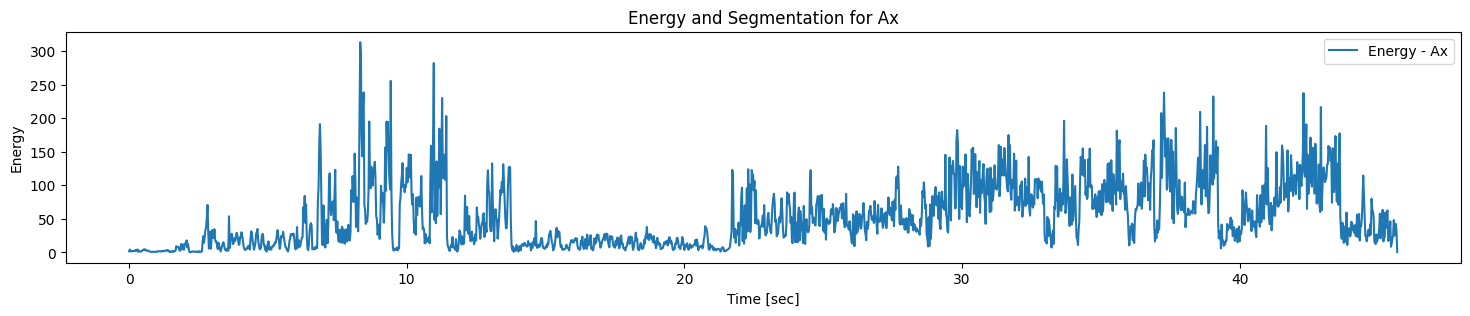

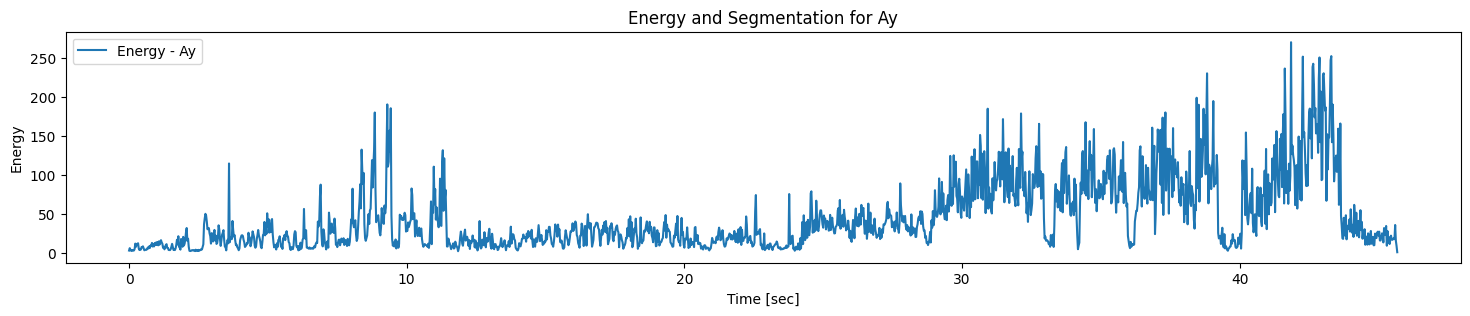

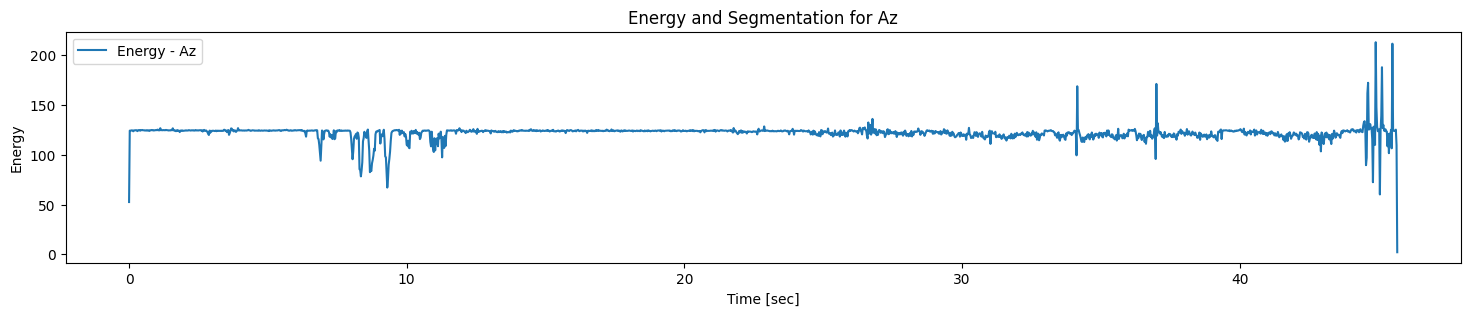

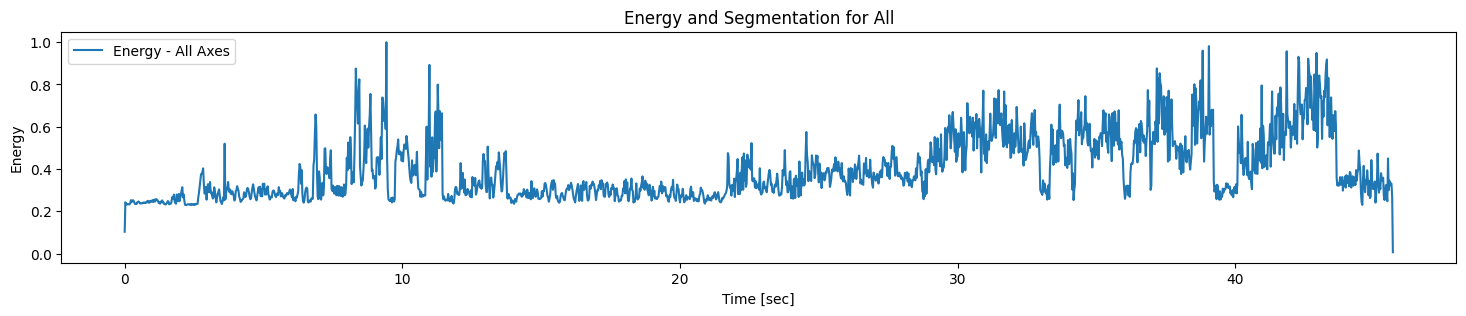

In [7]:
# Sampling frequency
fs = 1000

# Compute and plot STFT for Ay
t_Ax, f_Ax, Zxx_Ax = get_logscale_stft(accel_x, fs, scale=1.0)
t_Ay, f_Ay, Zxx_Ay = get_logscale_stft(accel_y, fs, scale=1.0)
t_Az, f_Az, Zxx_Az = get_logscale_stft(accel_z, fs, scale=1.0)

# Calculate energy for each axis
energy_Ax = calculate_energy(Zxx_Ax)
energy_Ay = calculate_energy(Zxx_Ay)
energy_Az = calculate_energy(Zxx_Az)
energy_accel_all = energy_Ax + energy_Ay + energy_Az
energy_accel_all = energy_accel_all / np.max(energy_accel_all)

# Segment based on energy for each axis
segments_Ax, num_segments_Ax = segment_energy(energy_Ax, threshold=0.75)
segments_Ay, num_segments_Ay = segment_energy(energy_Ay, threshold=0.75)
segments_Az, num_segments_Az = segment_energy(energy_Az, threshold=0.75)

# Plot energy and segmentation result for Ax
plt.figure(figsize=(18, 3))
plt.plot(t_Ax, energy_Ax, label='Energy - Ax')
plt.title('Energy and Segmentation for Ax')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Ax.png')  # Save the plot
plt.show()

# Plot energy and segmentation result for Ay
plt.figure(figsize=(18, 3))
plt.plot(t_Ay, energy_Ay, label='Energy - Ay')
plt.title('Energy and Segmentation for Ay')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Ay.png')  # Save the plot
plt.show()

# Plot energy and segmentation result for Az
plt.figure(figsize=(18, 3))
plt.plot(t_Az, energy_Az, label='Energy - Az')
plt.title('Energy and Segmentation for Az')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Az.png')  # Save the plot
plt.show()

# Plot energy and segmentation result for all axes
plt.figure(figsize=(18, 3))
plt.plot(t_Ax, energy_accel_all, label='Energy - All Axes')
plt.title('Energy and Segmentation for All')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_All.png')  # Save the plot
plt.show()

# Apply Continuous Wavelet Transform

c:\Users\dung2\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


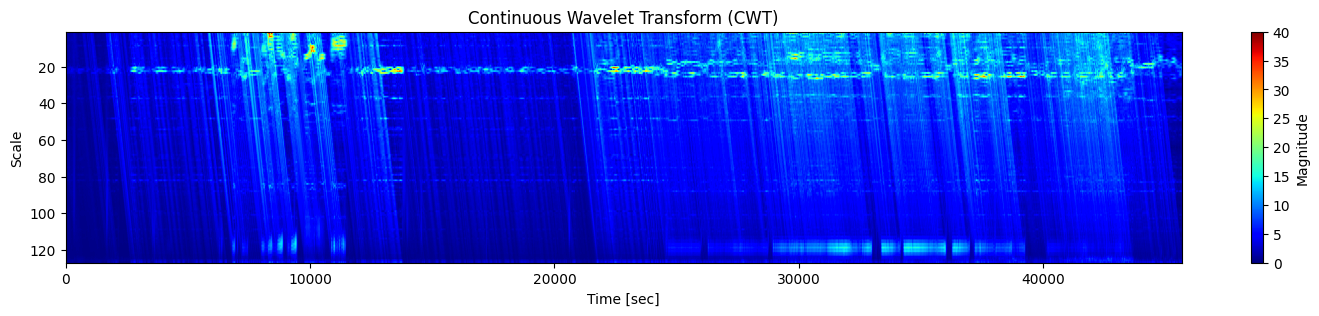

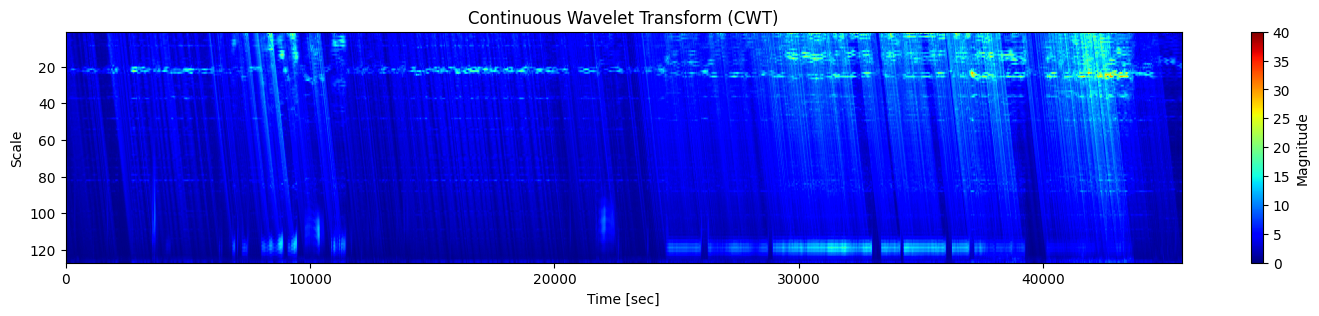

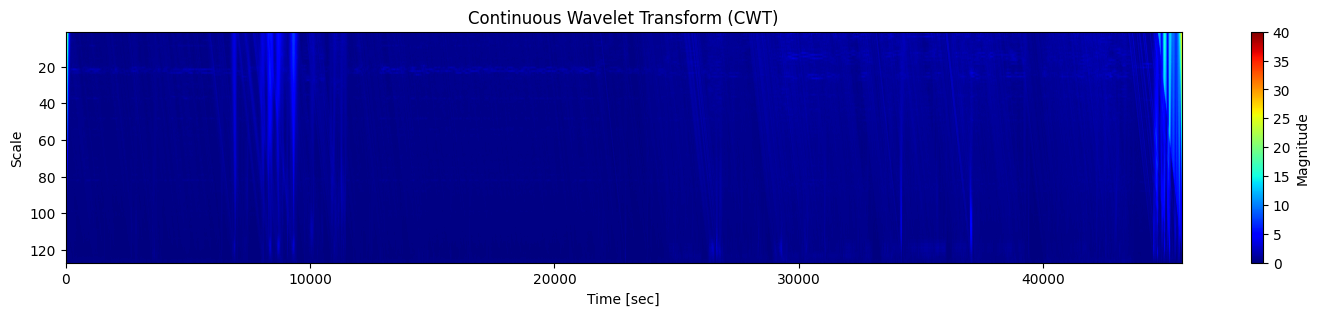

In [8]:
# Function to perform CWT and plot coefficients
def plot_cwt(signal, fs, title):
    # Define wavelet parameters
    wavelet = 'cmor'  # Complex Morlet wavelet
    scales = np.arange(1, 128)  # Range of scales

    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Convert scales to frequencies
    period = 1 / frequencies

    # Plot CWT coefficients with adjusted color scale
    plt.figure(figsize=(18,3))
    plt.imshow(np.abs(coefficients), extent=[0, len(t), min(scales), max(scales)], aspect='auto', cmap='jet', vmin=0, vmax=40)
    plt.colorbar(label='Magnitude')
    plt.title('Continuous Wavelet Transform (CWT)')
    plt.xlabel('Time [sec]')
    plt.ylabel('Scale')
    plt.gca().invert_yaxis()  # Invert y-axis to have increasing scale upwards
    plt.show()
    
# Sampling frequency
fs = 1000

# Apply CWT for Ax
plot_cwt(accel_x, fs, 'Ax')

# Apply CWT for Ay
plot_cwt(accel_y, fs, 'Ay')

# Apply CWT for Az
plot_cwt(accel_z, fs, 'Az')

# Plot the Gyroscope Data

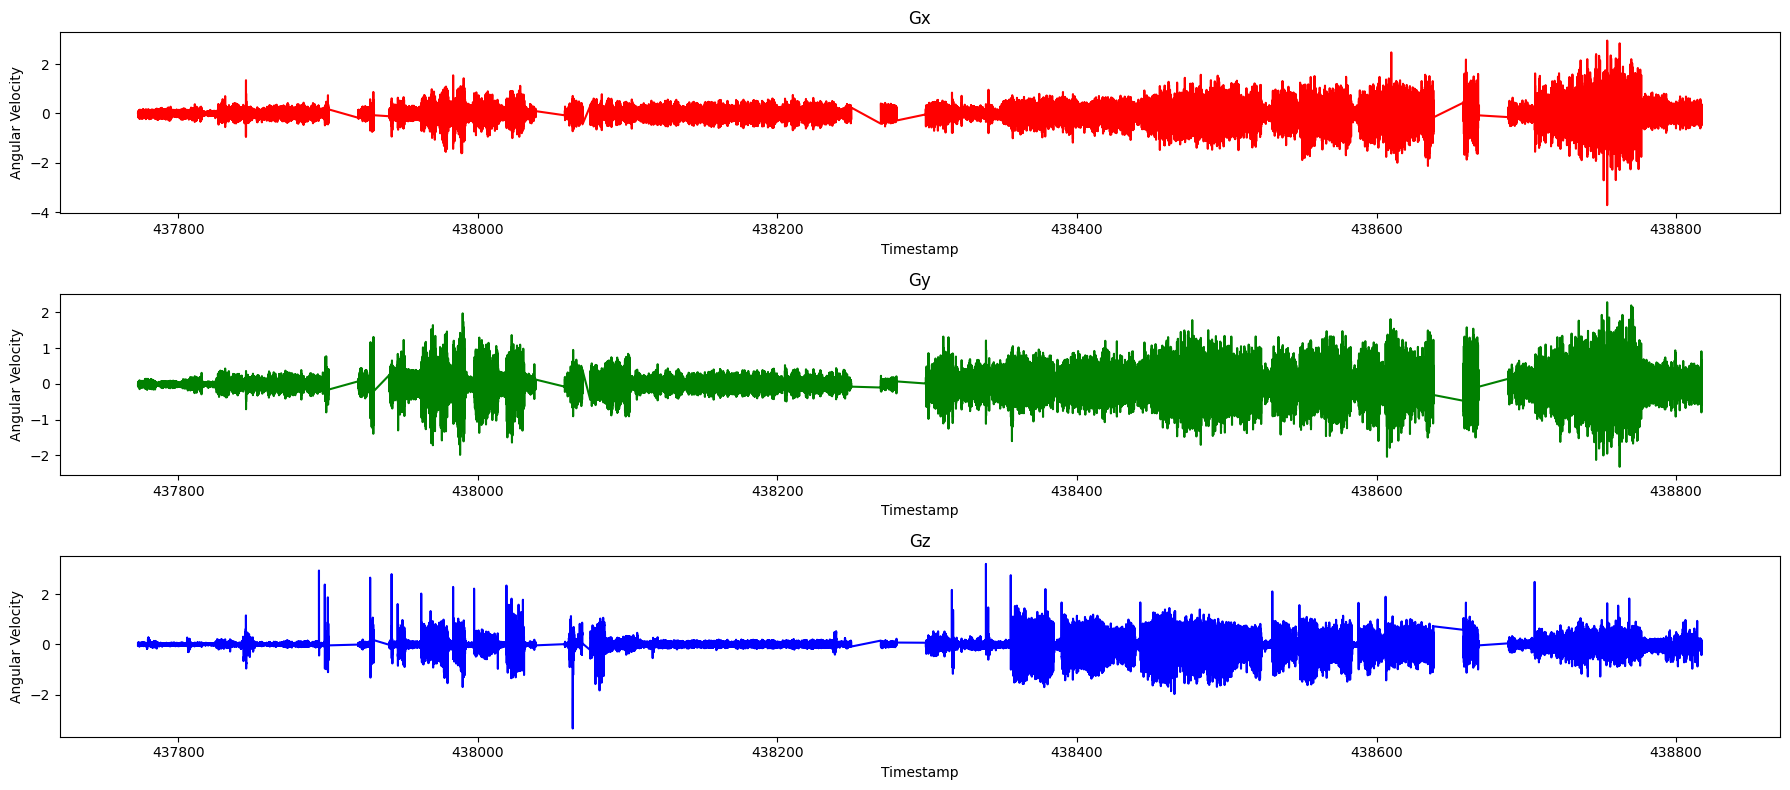

In [9]:
t = df['timestamp']
gyro_x = df['Gx']
gyro_y = df['Gy']
gyro_z = df['Gz']

# Creating subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 8))

# Plotting Gx
axs[0].plot(t, gyro_x, label="Gx", color='r')
axs[0].set_title('Gx')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Angular Velocity')

# Plotting Gy
axs[1].plot(t, gyro_y, label="Gy", color='g')
axs[1].set_title('Gy')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Angular Velocity')

# Plotting Gz
axs[2].plot(t, gyro_z, label="Gz", color='b')
axs[2].set_title('Gz')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Angular Velocity')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
fig.savefig('gyro_plot.png')

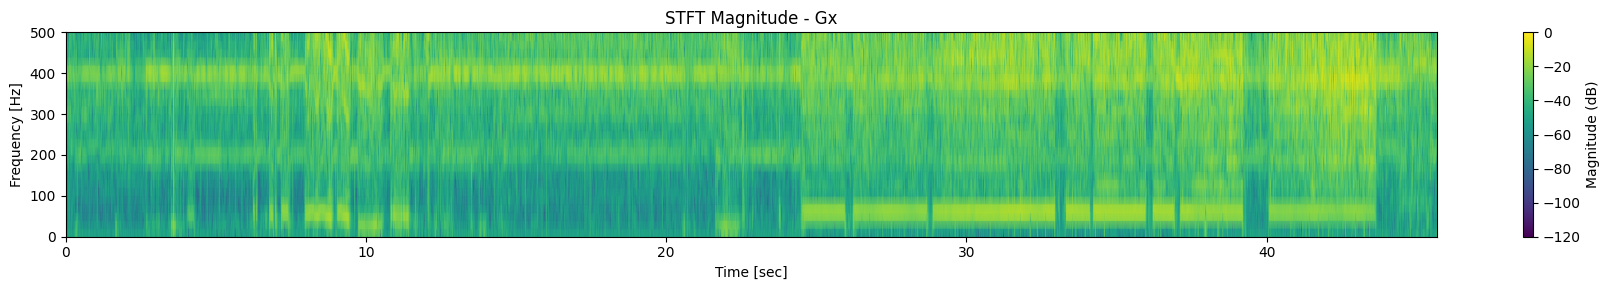

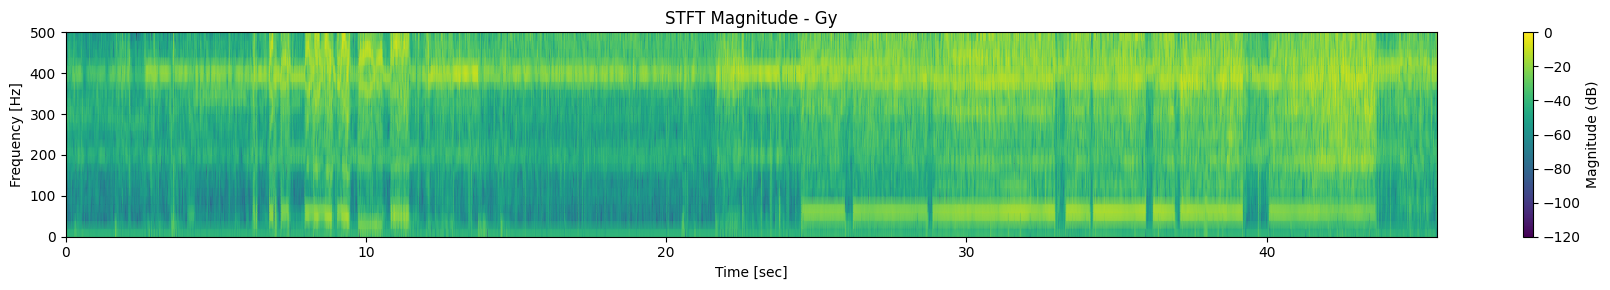

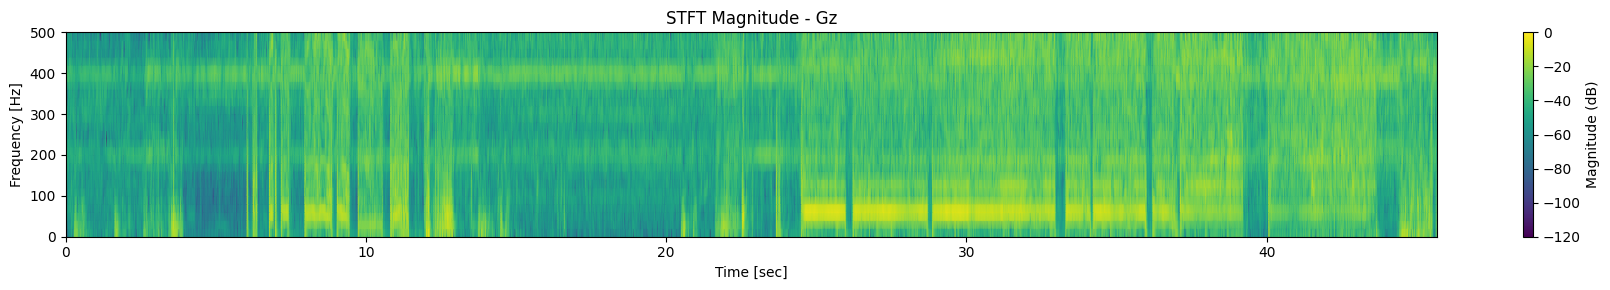

In [10]:
_, _, _ = plot_stft(gyro_x, fs, 'Gx', scale=1.0, vmin=-120, vmax=0, filename='stft_Gx.png', use_log_scale=True)
_, _, _ = plot_stft(gyro_y, fs, 'Gy', scale=1.0, vmin=-120, vmax=0, filename='stft_Gy.png', use_log_scale=True)
_, _, _ = plot_stft(gyro_z, fs, 'Gz', scale=1.0, vmin=-120, vmax=0, filename='stft_Gz.png', use_log_scale=True)

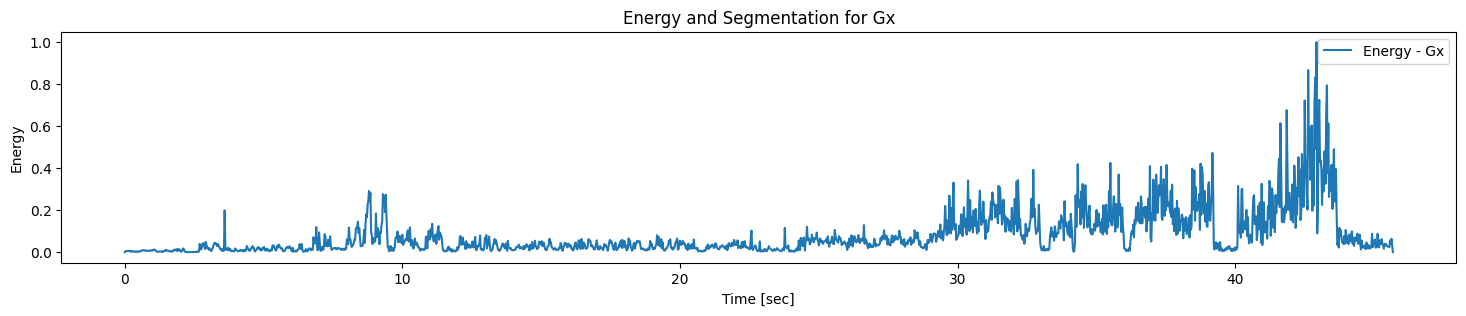

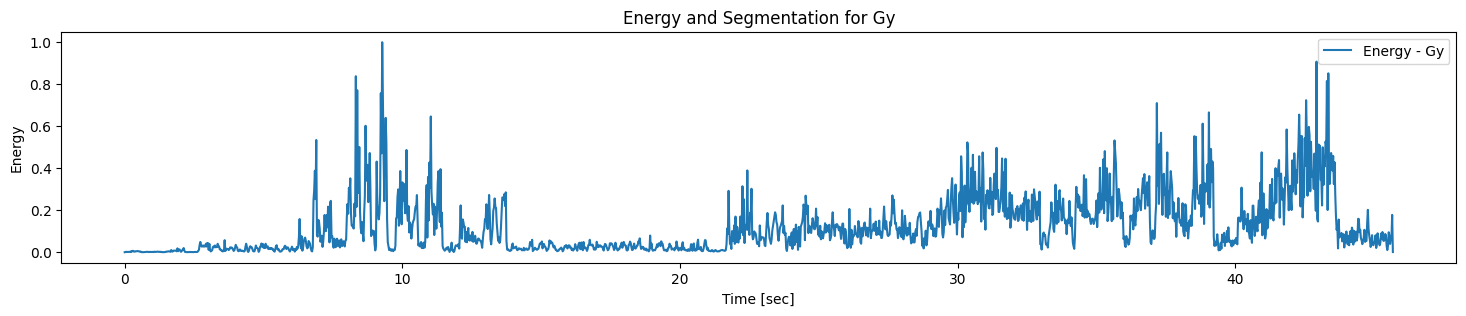

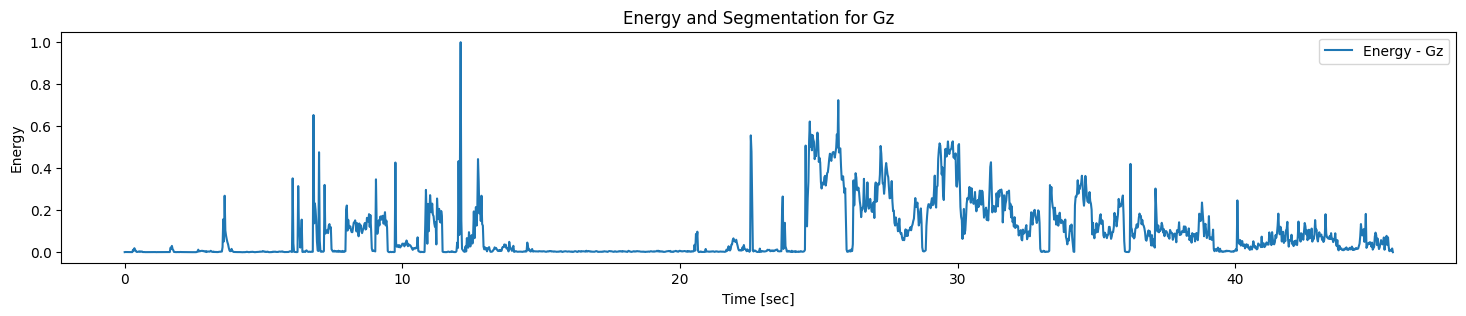

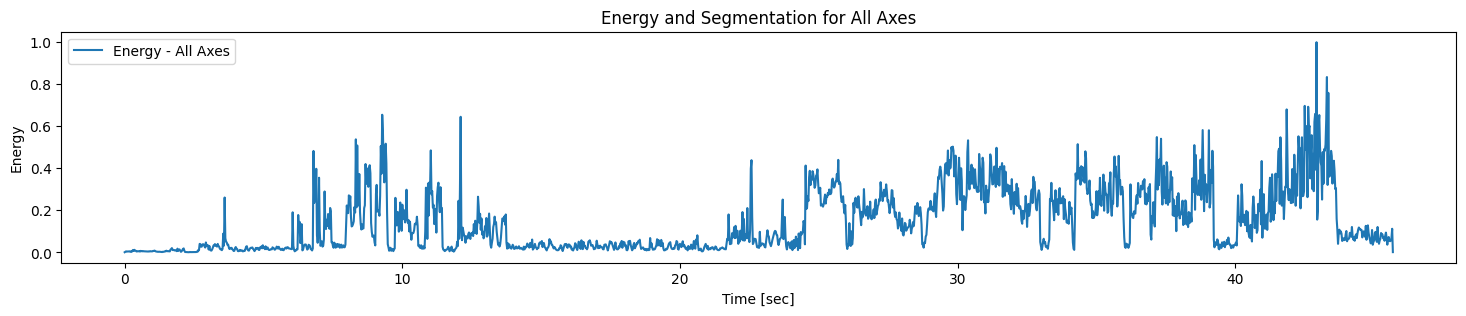

In [11]:
# Sampling frequency
fs = 1000

# Compute and plot STFT for Ay
t_Gx, f_Gx, Zxx_Gx = get_logscale_stft(gyro_x, fs, scale=1.0)
t_Gy, f_Gy, Zxx_Gy = get_logscale_stft(gyro_y, fs, scale=1.0)
t_Gz, f_Gz, Zxx_Gz = get_logscale_stft(gyro_z, fs, scale=1.0)

# Calculate energy for each axis
energy_Gx = calculate_energy(Zxx_Gx) / np.max(calculate_energy(Zxx_Gx))
energy_Gy = calculate_energy(Zxx_Gy) / np.max(calculate_energy(Zxx_Gy))
energy_Gz = calculate_energy(Zxx_Gz) / np.max(calculate_energy(Zxx_Gz))

energy_all = energy_Gx + energy_Gy + energy_Gz
energy_all = energy_all / np.max(energy_all) 

# Segment based on energy for each axis
segments_Gx, num_segments_Gx = segment_energy(energy_Gx, threshold=0.75)
segments_Gy, num_segments_Gy = segment_energy(energy_Gy, threshold=0.75)
segments_Gz, num_segments_Gz = segment_energy(energy_Gz, threshold=0.75)

# Plot energy and segmentation result for Gx
plt.figure(figsize=(18, 3))
plt.plot(t_Gx, energy_Gx, label='Energy - Gx')
# for segment in range(1, num_segments_Ax + 1):
#     plt.axvspan(t_Gx[np.where(segments_Ax == segment)[0][0]], t_Gx[np.where(segments_Ax == segment)[0][-1]], color='r', alpha=0.3, label='Segment {}'.format(segment) if segment == 1 else "")
plt.title('Energy and Segmentation for Gx')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Gx.png')
plt.show()

# Plot energy and segmentation result for Ay
plt.figure(figsize=(18, 3))
plt.plot(t_Gy, energy_Gy, label='Energy - Gy')
# for segment in range(1, num_segments_Ay + 1):
#     plt.axvspan(t_Gy[np.where(segments_Ay == segment)[0][0]], t_Gy[np.where(segments_Ay == segment)[0][-1]], color='r', alpha=0.3, label='Segment {}'.format(segment) if segment == 1 else "")
plt.title('Energy and Segmentation for Gy')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Gy.png')
plt.show()

# Plot energy and segmentation result for Az
plt.figure(figsize=(18, 3))
plt.plot(t_Gz, energy_Gz, label='Energy - Gz')
# for segment in range(1, num_segments_Az + 1):
#     plt.axvspan(t_Gy[np.where(segments_Az == segment)[0][0]], t_Gy[np.where(segments_Az == segment)[0][-1]], color='r', alpha=0.3, label='Segment {}'.format(segment) if segment == 1 else "")
plt.title('Energy and Segmentation for Gz')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_Gz.png')
plt.show()

# Plot energy and segmentation result for all axes
plt.figure(figsize=(18, 3))
plt.plot(t_Gx, energy_all, label='Energy - All Axes')
# for segment in range(1, num_segments_Ax + 1):
#     plt.axvspan(t_Gx[np.where(segments_Ax == segment)[0][0]], t_Gx[np.where(segments_Ax == segment)[0][-1]], color='r', alpha=0.3, label='Segment {}'.format(segment) if segment == 1 else "")
plt.title('Energy and Segmentation for All Axes')
plt.xlabel('Time [sec]')
plt.ylabel('Energy')
plt.legend()
plt.savefig('energy_segmentation_all_axes.png')
plt.show()


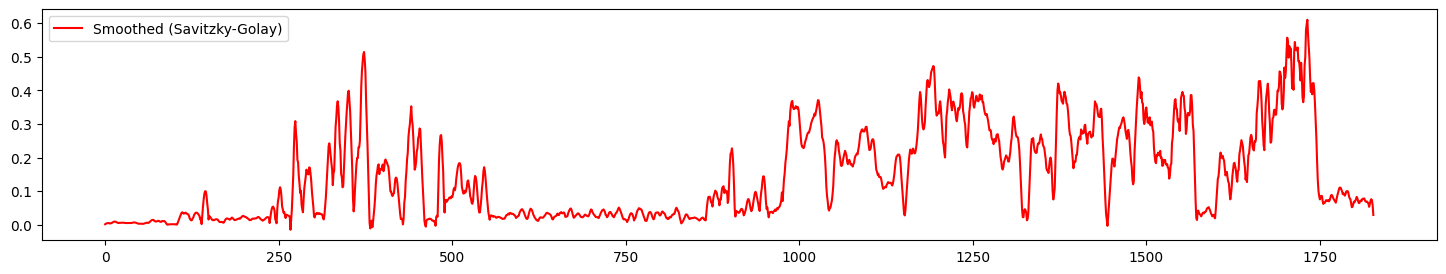

In [12]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_size = 11  # Must be odd
poly_order = 3
smoothed_series = savgol_filter(energy_all, window_size, poly_order)
smoothed_accel = savgol_filter(energy_accel_all, window_size, poly_order)

# Plot the original and smoothed time series
plt.figure(figsize=(18, 3))
# plt.plot(energy_all, label='Original')
plt.plot(smoothed_series, label='Smoothed (Savitzky-Golay)', color='red')
plt.legend()
plt.show()

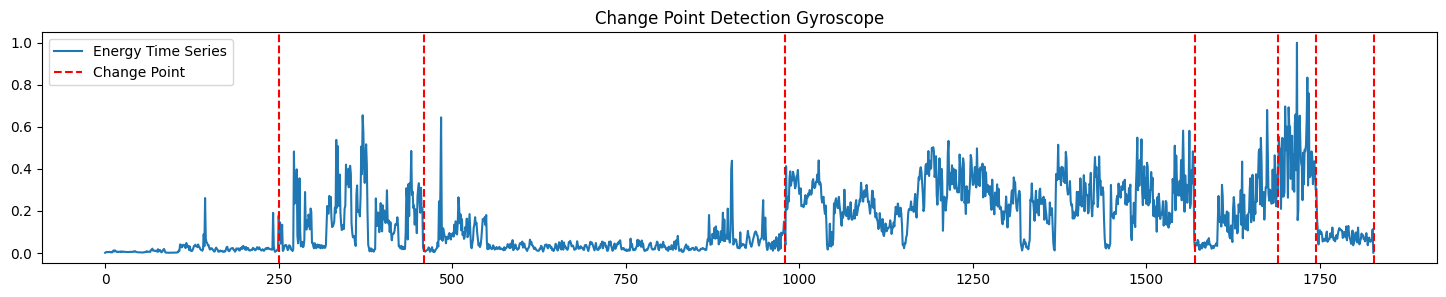

In [13]:
import ruptures as rpt

# Perform change point detection using the Binary Segmentation algorithm
algo = rpt.Binseg(model="l2").fit(energy_all)
result = algo.predict(n_bkps=6)  # Change the number of breakpoints (n_bkps) as needed

# Plot the original time series and the detected change points
plt.figure(figsize=(18, 3))
plt.plot(energy_all, label='Energy Time Series')

# Plot change points, but label only the first one
first = True
for cp in result:
    if first:
        plt.axvline(cp, color='red', linestyle='--', label='Change Point')
        first = False
    else:
        plt.axvline(cp, color='red', linestyle='--')

plt.title('Change Point Detection Gyroscope')
plt.legend()
plt.savefig('change_point_detection_gyro.png')
plt.show()

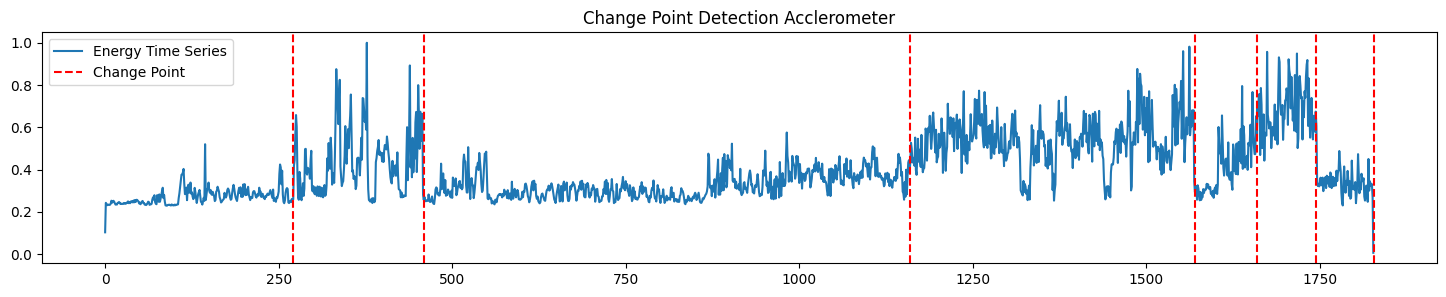

In [14]:
# Perform change point detection using the Binary Segmentation algorithm
algo = rpt.Binseg(model="l2").fit(energy_accel_all)
result = algo.predict(n_bkps=6)  # Change the number of breakpoints (n_bkps) as needed

# Plot the original time series and the detected change points
plt.figure(figsize=(18, 3))
plt.plot(energy_accel_all, label='Energy Time Series')

# Plot change points, but label only the first one
first = True
for cp in result:
    if first:
        plt.axvline(cp, color='red', linestyle='--', label='Change Point')
        first = False
    else:
        plt.axvline(cp, color='red', linestyle='--')

plt.title('Change Point Detection Acclerometer')
plt.legend()
plt.savefig('change_point_detection_accel.png')
plt.show()

# Statistical Analysis

In [15]:
def normalize_time_series(time_series):
    min_val = np.min(time_series)
    max_val = np.max(time_series)
    normalized_series = (time_series - min_val) / (max_val - min_val)
    return normalized_series

norm_gyro_z = normalize_time_series(gyro_z)

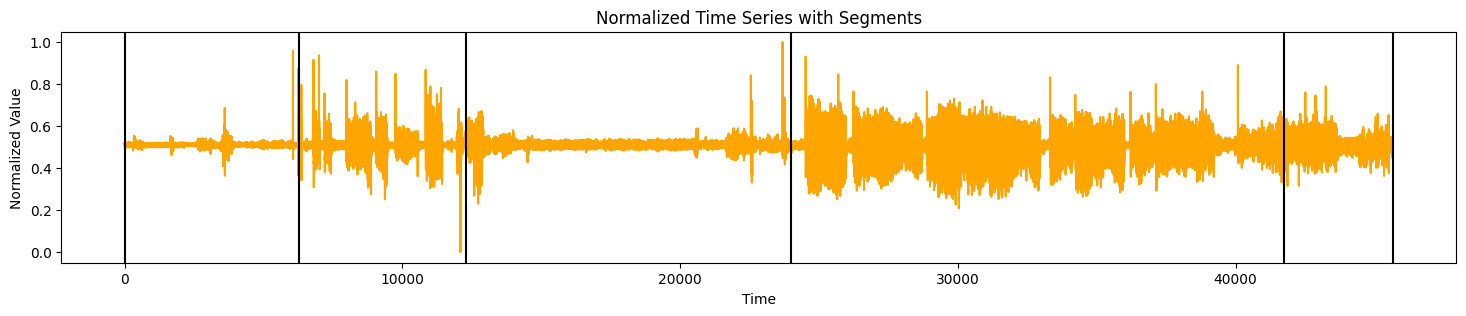

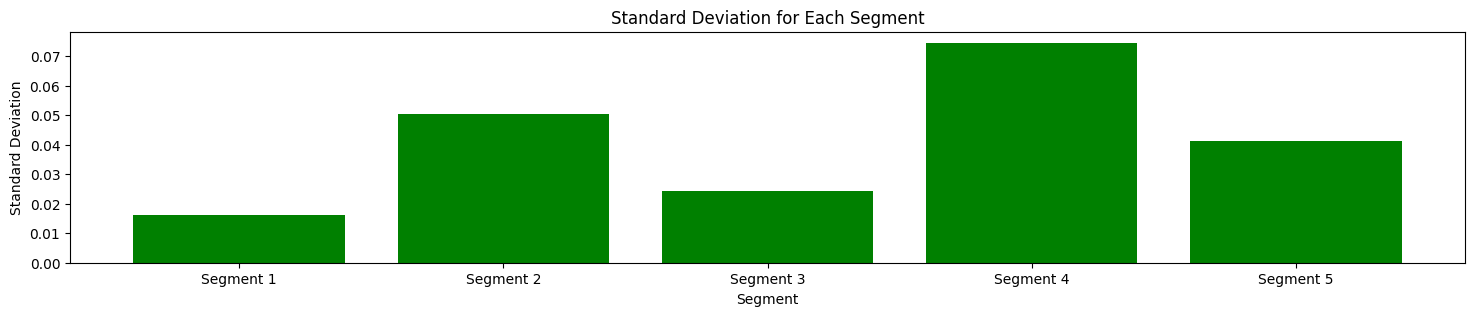

In [44]:
# Define segment indices
divider_indices = np.array([0, 6274, 12300, 24000, 41758, 45661])

# Plot the normalized time series
plt.figure(figsize=(18, 3))

# Plot the time series with colored segments
plt.plot(norm_gyro_z, color='orange')

# Add vertical lines to mark segments
for index in divider_indices:
    plt.axvline(x=index, color='black')

plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Normalized Time Series with Segments')
plt.savefig('normalized_time_series_with_segments.png')
plt.show()

# Calculate and plot the standard deviation for each segment
plt.figure(figsize=(18, 3))

# Initialize arrays to store standard deviation and segment lengths
segment_std = []
segment_lengths = []

# Iterate over segments
for i in range(len(divider_indices) - 1):
    start_index = divider_indices[i]
    end_index = divider_indices[i + 1]
    segment = norm_gyro_z[start_index:end_index]
    segment_lengths.append(len(segment))
    segment_std.append(np.std(segment))

# Plot standard deviation for each segment
plt.bar(range(len(segment_std)), segment_std, color='green')

# Set x-axis ticks and labels
plt.xticks(range(len(segment_std)), ['Segment {}'.format(i+1) for i in range(len(segment_std))])

plt.xlabel('Segment')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation for Each Segment')
plt.savefig('segment_std.png')
plt.show()


# Drilling Velocity

In [45]:
# Read the decoded data
decode_df = pd.read_csv('./data/lamhong2decoded.txt', sep='\t', header=None, names=['timestamp', 'xcor', 'ycor', 'zcor', 'Ax', 'Ay', 'Az'])
for col in decode_df.columns:
    if col == 'Az':
        continue
    decode_df[col] = decode_df[col].str.rstrip(',')
decode_df['timestamp'] = decode_df['timestamp'].str.rstrip(',')
print(decode_df)

          timestamp        xcor         ycor     zcor         Ax         Ay  \
0    437773.0000000  21.1656442  105.7746962   -9.837  0.0140000  0.0140000   
1    437774.0000000  21.1656442  105.7746961   -9.840  0.0140000  0.0140000   
2    437775.0000000  21.1656442  105.7746961   -9.848  0.0140000  0.0140000   
3    437777.0000000  21.1656442  105.7746961   -9.842  0.0140000  0.0140000   
4    437778.0000000  21.1656442  105.7746961   -9.847  0.0140000  0.0140000   
..              ...         ...          ...      ...        ...        ...   
870  438813.0000000  21.1656460  105.7746939  -11.483  0.0140000  0.0140000   
871  438814.0000000  21.1656461  105.7746939  -12.386  0.0140000  0.0140000   
872  438815.0000000  21.1656462  105.7746940  -12.782  0.0140000  0.0140000   
873  438816.0000000  21.1656462  105.7746939  -12.763  0.0140000  0.0140000   
874  438817.0000000  21.1656463  105.7746938  -12.757  0.0140000  0.0140000   

        Az  
0    0.010  
1    0.010  
2    0.010  

In [46]:
z_cor = np.array(decode_df["zcor"].values, dtype=np.float64)
time_decode = np.array(decode_df["timestamp"].values, dtype=np.float64)
time_decode_norm = [time - time_decode[0] for time in time_decode]
accel = np.zeros(len(time_decode))

In [47]:
def synchronize_imu_gnss(imu_timestamps, imu_data, gnss_timestamps, gnss_data):
    """
    Synchronize IMU and GNSS data by interpolating GNSS data to match IMU timestamps.

    Parameters:
    imu_timestamps (np.array): Array of IMU timestamps.
    imu_data (np.array): Array of IMU data.
    gnss_timestamps (np.array): Array of GNSS timestamps.
    gnss_data (np.array): Array of GNSS data.

    Returns:
    pd.DataFrame: DataFrame containing synchronized IMU and interpolated GNSS data.
    """
    # Interpolating GNSS data to match IMU timestamps
    interp_func = interp1d(gnss_timestamps, gnss_data, axis=0, kind='linear', fill_value='extrapolate')
    interpolated_gnss_data = interp_func(imu_timestamps)

    # Creating a DataFrame for synchronized data
    synchronized_data = pd.DataFrame({
        'imu_timestamp': imu_timestamps,
        'imu_data': list(imu_data),
        'gnss_data': list(interpolated_gnss_data)
    })

    return synchronized_data

In [48]:
synchronized_data = synchronize_imu_gnss(t_norm, accel_z, time_decode_norm, z_cor)

In [49]:
print(synchronized_data)

       imu_timestamp   imu_data  gnss_data
0              0.000  -9.480474  -9.837000
1              0.020 -10.301763  -9.837060
2              0.040 -10.221685  -9.837120
3              0.059  -9.405278  -9.837177
4              0.079 -10.289068  -9.837237
...              ...        ...        ...
45657       1044.039 -10.810552 -12.756766
45658       1044.058  -9.227544 -12.756652
45659       1044.078  -9.300786 -12.756532
45660       1044.098 -11.771490 -12.756412
45661       1044.118  -8.175785 -12.756292

[45662 rows x 3 columns]


In [52]:
def get_velocity_interval(z_cor, time_decode, divider_indices):
    """
    Calculate the velocity of the object in the z-direction over intervals defined by divider indices.

    Parameters:
    z_cor (np.array): Array of z-coordinate values.
    time_decode (np.array): Array of timestamps.
    divider_indices (np.array): Array of indices defining the intervals.

    Returns:
    np.array: Array of velocity values.
    """
    num_intervals = len(divider_indices) - 1
    velocity = np.zeros(num_intervals)
    
    for i in range(num_intervals):
        start_index = divider_indices[i]
        end_index = divider_indices[i + 1]
        
        displacement = z_cor[end_index] - z_cor[start_index]
        time_interval = time_decode[end_index] - time_decode[start_index]
        
        # Avoid division by zero
        if time_interval != 0:
            velocity[i] = displacement / time_interval

    return velocity

In [53]:
velocity = get_velocity_interval(synchronized_data['gnss_data'], synchronized_data['imu_timestamp'], divider_indices)

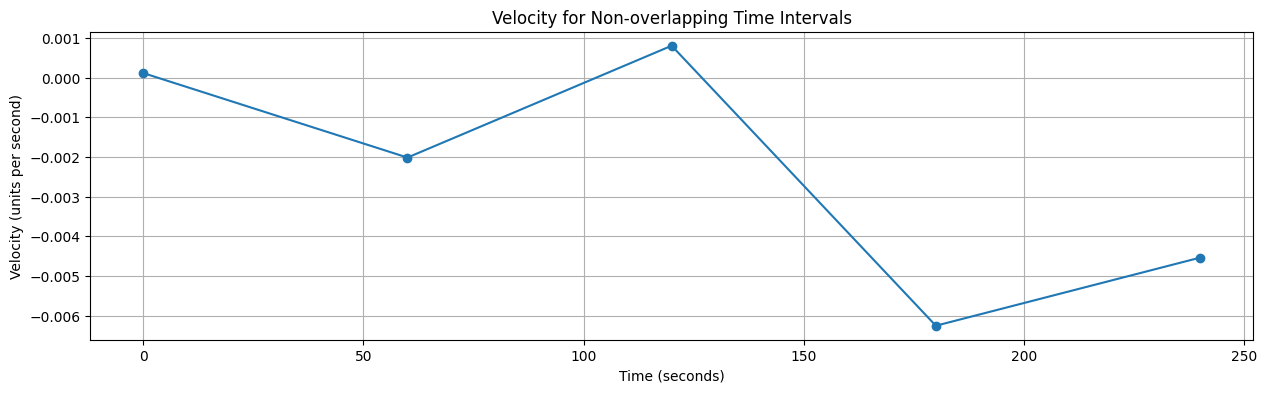

In [54]:
# Plotting
plt.figure(figsize=(15, 4))
plt.plot(np.arange(len(velocity)) * 60, velocity, marker='o', linestyle='-')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (units per second)')
plt.title('Velocity for Non-overlapping Time Intervals')
plt.grid(True)
plt.savefig('velocity.png')
plt.show()